# Comparison wind and surge data

This document makes a comparison between the performing of the SLR-models with wind data of with surge data

In [12]:
# Standard Python packages
import io

# Python packages that need to be installed using pip or anaconda:
# For computations
import pandas
import numpy as np

# For GIS related function
import pyproj
from shapely.geometry import LineString, Point

# For loading netcdf
import netCDF4

# For plotting
import matplotlib.pyplot as plt
import bokeh.palettes
import bokeh.plotting
from bokeh.models import HoverTool

# Initialize modules for the jupyter notebook format
from nbformat import current
%matplotlib inline
bokeh.io.output_notebook()

from IPython.display import display
import shutil

# Disable pandas warnings
pandas.options.mode.chained_assignment = None

Loading BokehJS ...

### Load standard functions

Define function to execute different notebook

In [13]:
def execute_notebook(nbfile):
    """Function to run other notebook in this notebook"""
    with io.open(nbfile,encoding="utf8") as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)


In [14]:
execute_notebook('../satellite/get-data.ipynb')

### Get PSMSL RLR annual data

In [15]:
station_names = [
    'Vlissingen', 
    'Hoek van Holland', 
    'Den Helder', 
    'Delfzijl', 
    'Harlingen', 
    'IJmuiden'
]
# Locatie wind data is 50 km uit kust vanuit IJmuiden
rlr_data = get_station_data(dataset_name='rlr_annual', coastline_code=150, names=station_names)

found point 52.3799 3.75
rlr_annual 20 rlr
rlr_annual 22 rlr
rlr_annual 23 rlr
rlr_annual 24 rlr
rlr_annual 25 rlr
rlr_annual 32 rlr


In [16]:
rlr_data

,lat,lon,name,coastline_code,station_code,quality,url,data
id,,,,,,,,
20,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
23,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
24,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
25,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...
32,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,year height interpolated flags ...


In [17]:
stations = [20, 22, 23, 24, 25, 32]

grouped = pandas.concat(rlr_data.loc[stations, 'data'].tolist())[['year', 'height', 'u', 'v', 'u2', 'v2']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890]

station_names = [st.capitalize() for st in rlr_data.loc[stations, 'name'].tolist()]

print(f'Stations of which the data is used: {", ".join(station_names)}')

Stations of which the data is used: Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden


### Fit models

The following models are fitted:
- linear model without wind or surge
- linear model with wind
- linear model with surge

In [29]:
tables = {}

# first the model without wind
linear_fit, names = linear_model(mean_df, with_wind=False, with_season=False)
tables['without'] = linear_fit.summary(yname='Sea-surface height', xname=names, title='Linear model without (1890-current)')
display(tables['without'])

# and then the model with wind
linear_with_wind_fit, names = linear_model(mean_df, with_wind=True, with_season=False)
tables['with wind'] = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model with wind (1948-current)'
)
# display(table)

# if (linear_fit.aic < linear_with_wind_fit.aic):
#     print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
# else:
#     print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')

# and then the model with wind

# Load surge and convert from meters to mm
surge = pandas.read_pickle('d:/Documents/2695.50 Zeespiegelstijging 2018/Data/surge.pkl') * 1000
# Calculate average over given stations, per year
average = surge[station_names].groupby(surge.index.year).mean().mean(axis=1)
# Construct dataframe and add to mean_df
surge_per_year = pandas.DataFrame(data=[average.mean()] * len(mean_df), index=mean_df['year'], columns=['surge'])
surge_per_year.loc[average.index, 'surge'] = average.values
surge_per_year.index.name = 'year'
if 'surge' not in mean_df.columns:
    mean_df = mean_df.merge(surge_per_year.reset_index(), on='year')

mean_df.head()

mean_df_corrected = mean_df.copy()
mean_df_corrected['height'] -= mean_df_corrected['surge']

linear_fit_corrected, names = linear_model(mean_df_corrected, with_wind=False, with_season=False)
table = linear_fit_corrected.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model corrected for surge (1980-current)'
)
display(table)

print(f'Linear model without wind or surge (1890-current): AIC = {linear_fit.aic}')
print(f'Linear model with wind (1948-current): AIC = {linear_with_wind_fit.aic}')
print(f'Linear model corrected for surge (1980-current): AIC = {linear_fit_corrected.aic}')



<class 'statsmodels.iolib.summary.Summary'>
"""
                     Linear model without (1890-current)                      
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     243.9
Date:                Wed, 18 Jul 2018   Prob (F-statistic):           1.38e-51
Time:                        17:56:01   Log-Likelihood:                -605.86
No. Observations:                 127   AIC:                             1220.
Df Residuals:                     123   BIC:                             1231.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -24.7060      2.841     -8.695      0.000     -30.330     -19.082
Trend          1.9072      0.071     27.028      0.000       1.768       2.047
Nodal U        5.9075      3.666      1.612      0.110      -1.348      13.163
Nodal V      -12.1065      3.637     -3.329      0.001     -19.305      -4.908
==============================================================================
Omnibus:                        3.424   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.115
Skew:                          -0.382   Prob(JB):                        0.211
Kurtosis:                       3.061   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
               Linear model corrected for surge (1980-current)                
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     322.9
Date:                Wed, 18 Jul 2018   Prob (F-statistic):           4.08e-58
Time:                        17:56:01   Log-Likelihood:                -588.10
No. Observations:                 127   AIC:                             1184.
Df Residuals:                     123   BIC:                             1196.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.7182      2.471     -9.600      0.000     -28.609     -18.828
Trend          1.9091      0.061     31.115      0.000       1.788       2.031
Nodal U        5.1891      3.187      1.628      0.106      -1.120      11.498
Nodal V      -10.4890      3.162     -3.317      0.001     -16.749      -4.229
==============================================================================
Omnibus:                        3.340   Durbin-Watson:                   1.534
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                2.807
Skew:                          -0.280   Prob(JB):                        0.246
Kurtosis:                       3.465   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Linear model without wind or surge (1890-current): AIC = 1219.7180419590743
Linear model with wind (1948-current): AIC = 1196.8226390701186
Linear model corrected for surge (1980-current): AIC = 1184.205592241473


Note that in the 3th approach above the annual average sea level is corrected for the surge from the model results. This approach impplicitly assumes the model surge output to be correct. The model results are however only available from 1980 onwards, for the previous years the average surge is used. The AIC is larger for this model, which means that correcting the average sea level for surge, does not give a better fit!

In [19]:
print(f'Average surge for ({", ".join(station_names)}) = {surge[station_names].mean().mean()} mm')

Average surge for (Vlissingen, Hoek van holland, Den helder, Delfzijl, Harlingen, Ijmuiden) = -0.9473910066790093 mm


In [20]:
# plot the model with wind. 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)

fig.circle(
    mean_df.year,
    mean_df.height,
    line_width=1,
    legend='Yearly mean sea level',
    color='black',
    alpha=0.5
)

fig.circle(
    mean_df_corrected.year[mean_df_corrected.year >= 1980],
    mean_df_corrected.height[mean_df_corrected.year >= 1980],
    line_width=1,
    legend='Yearly mean sea level corrected for surge',
    color='orange',
    alpha=0.5
)

fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level, corrected for wind influence'
)
fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level', 
    color='green',
    alpha=0.5
)

fig.line(
    linear_fit_corrected.model.exog[:, 1] + 1970, 
    linear_fit_corrected.predict(), 
    line_width=3, 
    legend='Current sea level, corrected for surge', 
    color='red',
    line_dash='dashed',
    alpha=0.5
)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
fig.legend.click_policy = "hide"

bokeh.io.show(fig)

In a second approach we add the modelled surge as a variable, so the coefficient of it can be determined. This way the years prior to 1980 can also be disregarded.

To estimate the impact of adding the modelled surge, we compare the residuals to the surge:

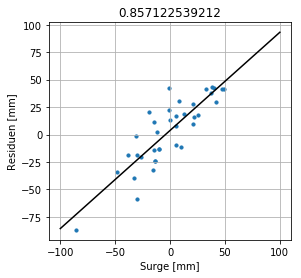

In [21]:
yearmin = 1980
indices = mean_df['year'] >= yearmin

fig, ax = plt.subplots()

xdata = mean_df.loc[indices, 'surge'].values
ydata = linear_fit.resid.values[indices]

ax.scatter(xdata, ydata, s=10)
ax.grid()
ax.set_ylabel('Residuen [mm]')
ax.set_xlabel('Surge [mm]')
ax.set_aspect(1.0)

x = np.linspace(-100, 100, 100)
p = np.polyfit(xdata, ydata, 1)
y = np.polyval(p, x)
ax.plot(x, y, color='k')

ax.set_title(np.corrcoef(xdata, ydata)[0, 1])

there does not seem to be no relation. Disregarding the rest of the linear model, we compare the annual mean of the sea level to the annual mean of the surge.

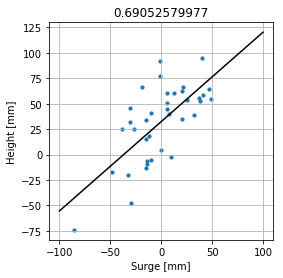

In [22]:
yearmin = 1980
indices = mean_df['year'] >= yearmin

fig, ax = plt.subplots()

ax.scatter(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values, s=10)
ax.grid()
ax.set_xlabel('Surge [mm]')
ax.set_ylabel('Height [mm]')
ax.set_aspect(1.0)

x = np.linspace(-100, 100, 100)
p = np.polyfit(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values, 1)
y = np.polyval(p, x)
ax.plot(x, y, color='k')

ax.set_title(np.corrcoef(mean_df.loc[indices, 'surge'].values, mean_df.loc[indices, 'height'].values)[0, 1])

There seems to be no significant relation, but we add it to the model nonetheless:

In [23]:
def linear_model_with_surge(df):
    """
    Return the fit from the linear model on the given dataset df.
    Wind and season can be enabled and disabled
    """
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613),
        df['surge']# * (df['year'] >= 1980)    
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Surge']
        
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit()
    return fit, names

In [24]:
linear_fit_with_surge, names = linear_model_with_surge(mean_df)
tables['with surge'] = linear_fit_with_surge.summary(
    yname='Sea-surface height', 
    xname=names, 
    title='Linear model with surge (1980-current)'
)


In [25]:
display(tables['without'])
display(tables['with wind'])
display(tables['with surge'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Linear model without (1890-current)                      
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     243.9
Date:                Wed, 18 Jul 2018   Prob (F-statistic):           1.38e-51
Time:                        17:51:00   Log-Likelihood:                -605.86
No. Observations:                 127   AIC:                             1220.
Df Residuals:                     123   BIC:                             1231.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -24.7060      2.841     -8.695      0.000     -30.330     -19.082
Trend          1.9072      0.071     27.028      0.000       1.768       2.047
Nodal U        5.9075      3.666      1.612      0.110      -1.348      13.163
Nodal V      -12.1065      3.637     -3.329      0.001     -19.305      -4.908
==============================================================================
Omnibus:                        3.424   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.115
Skew:                          -0.382   Prob(JB):                        0.211
Kurtosis:                       3.061   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     183.6
Date:                Wed, 18 Jul 2018   Prob (F-statistic):           9.63e-55
Time:                        17:51:00   Log-Likelihood:                -592.41
No. Observations:                 127   AIC:                             1197.
Df Residuals:                     121   BIC:                             1214.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -69.0715      9.850     -7.013      0.000     -88.571     -49.572
Trend          1.8757      0.064     29.103      0.000       1.748       2.003
Nodal U        5.3673      3.329      1.612      0.110      -1.224      11.958
Nodal V      -11.5708      3.311     -3.495      0.001     -18.125      -5.016
Wind U^2       6.0411      1.174      5.146      0.000       3.717       8.365
Wind V^2      -0.0600      1.591     -0.038      0.970      -3.209       3.089
==============================================================================
Omnibus:                        8.235   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.372
Skew:                          -0.493   Prob(JB):                       0.0152
Kurtosis:                       3.781   Cond. No.                         172.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with surge (1980-current)                    
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     250.9
Date:                Wed, 18 Jul 2018   Prob (F-statistic):           7.49e-58
Time:                        17:52:21   Log-Likelihood:                -587.85
No. Observations:                 127   AIC:                             1186.
Df Residuals:                     122   BIC:                             1200.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.8161      2.480     -9.604      0.000     -28.725     -18.907
Trend          1.9090      0.061     31.047      0.000       1.787       2.031
Nodal U        5.2603      3.196      1.646      0.102      -1.066      11.586
Nodal V      -10.6493      3.177     -3.352      0.001     -16.939      -4.359
Surge          0.9009      0.142      6.325      0.000       0.619       1.183
==============================================================================
Omnibus:                        3.618   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.093
Skew:                          -0.295   Prob(JB):                        0.213
Kurtosis:                       3.486   Cond. No.                         57.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient of the surge is just below 0 while we expect it to be around 1.0. Adding the average surge does not have the expected results. The overal average of the surge is -1 mm, so a negative effect. The resulting negative coefficient does agree with the positive coefficient we found for the wind speed.

In [26]:
# plot the model with wind. 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)

fig.circle(
    mean_df.year,
    mean_df.height,
    line_width=1,
    legend='Yearly mean sea level',
    color='black',
    alpha=0.5
)

fig.circle(
    mean_df_corrected.year[mean_df_corrected.year >= 1980],
    mean_df_corrected.height[mean_df_corrected.year >= 1980],
    line_width=1,
    legend='Yearly mean sea level corrected for surge',
    color='orange',
    alpha=0.5
)

fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level, corrected for wind influence'
)

fig.line(
    linear_fit_with_surge.model.exog[:, 1] + 1970, 
    linear_fit_with_surge.predict(), 
    line_width=3, 
    legend='Current sea level, corrected for fitted surge', 
    color='red',
    alpha=0.5
)

fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level', 
    color='green',
    line_dash='dashed',
    alpha=0.5
)

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
fig.legend.click_policy = "hide"

bokeh.io.show(fig)